In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Some new snapshot "features"

OpenPathSampling allows the fields of a snapshot (known as "snapshot features") to vary depending on the engine. This notebook demonstrates several new snapshot features that I added to OPS.

An important concept here is the use of "duck typing" in Python. The name comes from a quote by poet James Whitcomb Riley: "When I see a bird that walks like a duck and swims like a duck and quacks like a duck, I call that bird a duck." The behavior of the object defines the nomenclature, not the other way around.

Similarly, OpenPathSampling `Snapshot`s have a certain set of "features." As long as these features share common names and interpretations, they can be reused in various parts of the code. However, code should be ready to fail gracefully if these features do not exist.

Snapshot features in OpenPathSampling do not need to be data stored per-snapshot: they can instead be computed on the fly, or stored as a single copy relevant for all snapshots made by the same `DynamicsEngine` instance. None of the new features described here are stored inside the snapshot itself.

This notebook covers several features, which have been implemented in both the toy engine and the OpenMM engine. Other engines should consider implementing them as well:

* `masses`
* `n_degrees_of_freedom`
* `instantaneous_temperature`

One of the important points is that OpenMM uses units, which can give different outputs than the unitless toy engine. These details will be discussed below.

In [2]:
# toy
from openpathsampling.engines import toy as toy_engine
topology = toy_engine.Topology(
    n_atoms=1,
    n_spatial=2,
    masses=[1.0],
    pes=toy_engine.LinearSlope(m=[0.0, 0.0], c=0.0)  # flat plane
)
options = {
    'integ': toy_engine.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
    'n_frames_max' : 5000,
    'n_steps_per_frame' : 1
}

engine_1 = toy_engine.Engine(
    options=options,
    topology=topology
)

snapshot = toy_engine.Snapshot(
    coordinates=np.array([[0.0, 0.0]]),
    velocities=np.array([[0.0, 0.0]]),
    engine=engine_1
)

# we'll start from zero KE, and watch the thermostat kick us up to the correct value
toy_trajectory = engine_1.generate(snapshot, running=[lambda traj, foo: len(traj) < 2000])

In [3]:
# OpenMM
from openpathsampling.engines import openmm as openmm_engine
import openmmtools as omt
import simtk.unit as u

test_system = omt.testsystems.AlanineDipeptideVacuum()
template = openmm_engine.snapshot_from_testsystem(test_system)
engine_2 = openmm_engine.Engine(
    topology=template.topology,
    system=test_system.system,
    integrator=omt.integrators.VVVRIntegrator()
)
openmm_trajectory = engine_2.generate(template, running=[lambda traj, foo: len(traj) < 500])

## `masses`

In [4]:
print toy_trajectory[0].masses[0]

1.0


In [5]:
print openmm_trajectory[0].masses[0]
print openmm_trajectory[0].masses[0].in_units_of(u.gram)
print openmm_trajectory[0].masses_per_mole[0]

1.67373508487e-24 mol Da
1.67373508487e-24 g
1.007947 Da


## `n_degrees_of_freedom`

In [6]:
print toy_trajectory[10].n_degrees_of_freedom

2


In [7]:
# this gives us 3 * n_atoms -- number of DOFs without constraints
print 3 * len(openmm_trajectory[10].xyz)

66


In [8]:
print openmm_trajectory[10].n_degrees_of_freedom

51


In the OpenMM example, 66-51=15 possible degrees of freedom have been removed. In this case, that's 3 from linear momentum, 3 from angular momentum, and the remaining 9 come from constraining distances in bonds to hydrogens.

## `instantaneous_temperature`

In [9]:
toy_instantaneous = [s.instantaneous_temperature for s in toy_trajectory]

toy_cumulative = [toy_instantaneous[0]]
for T_inst in toy_instantaneous[1:]:
    toy_cumulative.append(toy_cumulative[-1] + T_inst)
toy_running_average = [toy_cumulative[i] / float(i+1) 
                       for i in range(len(toy_cumulative))]

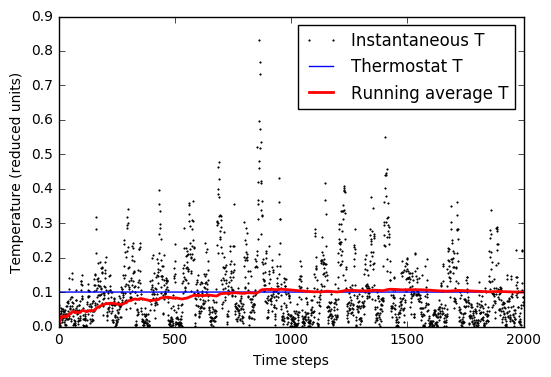

In [10]:
plt.plot(toy_instantaneous, 'k.', markersize=2, label='Instantaneous T')
plt.plot([0.1]*len(toy_instantaneous), ls='-', c='b', label='Thermostat T')
plt.plot(toy_running_average, lw=2, c='r', label='Running average T')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Temperature (reduced units)")

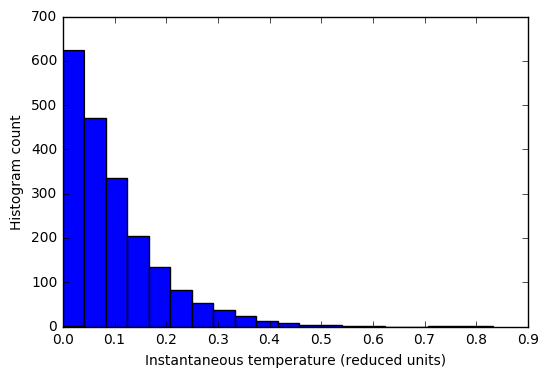

In [11]:
(counts, bins, patches) = plt.hist(toy_instantaneous, bins=20)
plt.xlabel("Instantaneous temperature (reduced units)")
plt.ylabel("Histogram count")

In [12]:
openmm_instantaneous = [s.instantaneous_temperature / u.kelvin
                        for s in openmm_trajectory[1:]]

openmm_cumulative = [openmm_instantaneous[0]]
for T_inst in openmm_instantaneous[1:]:
    openmm_cumulative.append(openmm_cumulative[-1] + T_inst)
openmm_running_average = [openmm_cumulative[i] / float(i+1) 
                          for i in range(len(openmm_cumulative))]

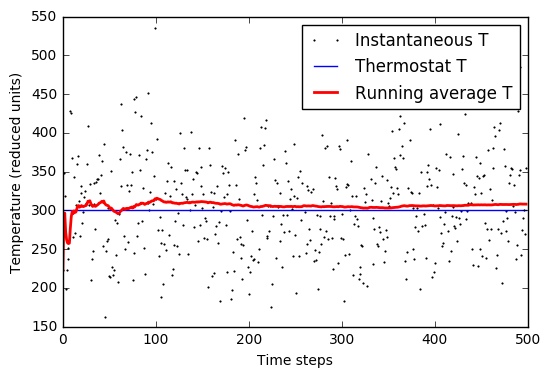

In [13]:
plt.plot(openmm_instantaneous, 'k.', markersize=2, label='Instantaneous T')
plt.plot([300]*len(openmm_instantaneous), ls='-', c='b', label='Thermostat T')
plt.plot(openmm_running_average, lw=2, c='r', label='Running average T')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Temperature (reduced units)")

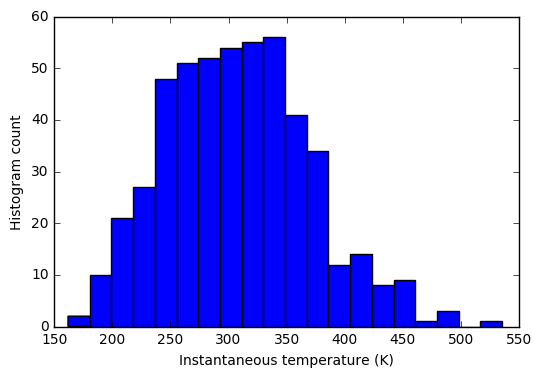

In [14]:
(counts, bins, patches) = plt.hist(openmm_instantaneous, bins=20)
plt.xlabel("Instantaneous temperature (K)")
plt.ylabel("Histogram count")